In [1]:
"""Script to generate the results for the literature review.
"""

import utils as ut
import analysis as anl

df = ut.load_data_items()
results_df = ut.load_reported_results_data()
ut.check_data_items(df)


In [2]:
import os
import logging
import logging.config
from collections import OrderedDict
import subprocess

import pandas as pd
# import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
import matplotlib as mpl
import seaborn as sns
import numpy as np
from PIL import Image


In [38]:
df['Task/Paradigm']

0                                     Driving Game (GTA)
1                                          Motor Imagery
2                                                  Sleep
3       Resting State, Eyes Open, Eyes Closed, Seizures.
4                                      SSVEP (with LEDs)
                             ...                        
158    P300 Speller, 6x6 Matrix.\nBCI Competition III...
159    Ongoing recording in a clinical settings \n(to...
160    Motor Imagery & Real - Finger vs Wrist on the ...
162    On going EEG with and without seizures\n(Bonn ...
163    Finger Taping. (BCI Motor Task, with real move...
Name: Task/Paradigm, Length: 154, dtype: object

In [195]:
data_df = ut.split_column_with_multiple_entries(
    df, ['Data - samples', 'Data - time'], ref_col=['Citation', 'Main domain', 'Features (clean)'], 
    sep=';\n', lower=False)

# Remove N/M and TBD
col = 'Data - samples'
data_df.loc[data_df[col].isin(['N/M', 'TBD', '[TBD]']), col] = np.nan
data_df[col] = data_df[col].astype(float)

col2 = 'Data - time'
data_df.loc[data_df[col2].isin(['N/M', 'TBD', '[TBD]']), col2] = np.nan
data_df[col2] = data_df[col2].astype(float)

# Wrap main domain text
data_df['Main domain'] = data_df['Main domain'].apply(
    ut.wrap_text, max_char=13)

# Extract ratio
data_df['data_ratio'] = data_df['Data - samples'] / data_df['Data - time']
data_df = data_df.sort_values(['Main domain', 'data_ratio'])

acc_df = results_df[results_df['Metric'] == 'accuracy']  # Extract accuracy rows only

# Create new column that contains both citation and task information
acc_df.loc[:, 'citation_task'] = acc_df[['Citation', 'Task']].apply(
    lambda x: ' ['.join(x) + ']', axis=1)

# Create a new column with the year
acc_df.loc[:, 'year'] = acc_df['Citation'].apply(
    lambda x: int(x[x.find('2'):x.find('2') + 4]))

acc_df_best_proposed = acc_df[acc_df['model_type'] == 'Proposed'].sort_values('Result', ascending=False).drop_duplicates('Citation')
acc_df_best_baseline_trad = acc_df[acc_df['model_type'] == 'Baseline (traditional)'].sort_values('Result', ascending=False).drop_duplicates('Citation')

acc_df_best_proposed = acc_df_best_proposed[acc_df_best_proposed['Citation'].isin(acc_df_best_baseline_trad['Citation'])]
acc_df_best_baseline_trad = acc_df_best_baseline_trad[acc_df_best_baseline_trad['Citation'].isin(acc_df_best_proposed['Citation'])]

acc_df_best_proposed = acc_df_best_proposed.sort_values('Citation')
acc_df_best_baseline_trad = acc_df_best_baseline_trad.sort_values('Citation')
acc_df_best_baseline_trad.index = acc_df_best_baseline_trad['citation_task']
acc_df_best_proposed.index = acc_df_best_proposed['citation_task']


# acc_df_best_proposed = acc_df[acc_df['model_type'] == 'Proposed'].sort_values('Result', ascending=False).drop_duplicates('citation_task')
# acc_df_best_baseline_trad = acc_df[acc_df['model_type'] == 'Baseline (traditional)'].sort_values('Result', ascending=False).drop_duplicates('citation_task')

# acc_df_best_proposed = acc_df_best_proposed[acc_df_best_proposed['citation_task'].isin(acc_df_best_baseline_trad['citation_task'])]
# acc_df_best_baseline_trad = acc_df_best_baseline_trad[acc_df_best_baseline_trad['citation_task'].isin(acc_df_best_proposed['citation_task'])]

# acc_df_best_proposed = acc_df_best_proposed.sort_values('citation_task')
# acc_df_best_baseline_trad = acc_df_best_baseline_trad.sort_values('citation_task')
# acc_df_best_baseline_trad.index = acc_df_best_baseline_trad['citation_task']
# acc_df_best_proposed.index = acc_df_best_proposed['citation_task']

acc_diff = pd.DataFrame({
    'Difference': acc_df_best_proposed['Result'] - acc_df_best_baseline_trad['Result'],
    'Citation': acc_df_best_baseline_trad['Citation'],
    'citation_task': acc_df_best_baseline_trad['citation_task']
}).reset_index(drop=True)
acc_diff = acc_diff[acc_diff['Difference'] < 0.7]
data_df_beg = data_df.copy()
data_df_beg = data_df_beg.dropna(subset=['Citation', 'Data - time', 'Data - samples'])
data_df = pd.merge(data_df, acc_diff, on='Citation')
data_df = data_df.dropna(subset=['Citation', 'Difference', 'Data - time', 'Data - samples'])

c:\Users\ms261489\Documents\src\dl-eeg-review\code\utils.py:106: UserWarning: 1 rows had incompatible numbers of elements in the columns of interest and were dropped:
  warnings.warn('{} rows had incompatible numbers of elements in the '
c:\Users\ms261489\Documents\src\dl-eeg-review\code\utils.py:110: UserWarning: 	Morabito2016
  warnings.warn('\t{}'.format(df.iloc[i].loc['Citation']))
C:\Users\ms261489\AppData\Local\Temp\ipykernel_25032\2412803253.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_df.loc[:, 'citation_task'] = acc_df[['Citation', 'Task']].apply(
C:\Users\ms261489\AppData\Local\Temp\ipykernel_25032\2412803253.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [196]:
acc_df_best_baseline_trad

,Citation,Task,Metric,Model,Description,Architecture,Result,model_type,citation_task,year
citation_task,,,,,,,,,,
Acharya2017 [seizure detection],Acharya2017,seizure detection,accuracy,trad3,Fuzzy sugeno,-,0.9970,Baseline (traditional),Acharya2017 [seizure detection],2017
Alhagry2017 [emotion recognition (valence)],Alhagry2017,emotion recognition (valence),accuracy,trad2,[3],-,0.7341,Baseline (traditional),Alhagry2017 [emotion recognition (valence)],2017
Alomari2013 [motor imagery],Alomari2013,motor imagery,accuracy,trad1,SVM,-,0.8841,Baseline (traditional),Alomari2013 [motor imagery],2013
An2014 [motor imagery],An2014,motor imagery,accuracy,trad1,SVM,-,0.7675,Baseline (traditional),An2014 [motor imagery],2014
Aznan2018 [SSVEP],Aznan2018,SSVEP,accuracy,trad1,SVM gaussian,-,0.5100,Baseline (traditional),Aznan2018 [SSVEP],2018
...,...,...,...,...,...,...,...,...,...,...
Zheng2014 [emotion classification],Zheng2014,emotion classification,accuracy,trad1,GELM,-,0.8567,Baseline (traditional),Zheng2014 [emotion classification],2014
Zheng2015 [emotion recognition],Zheng2015,emotion recognition,accuracy,trad1,SVM,-,0.8399,Baseline (traditional),Zheng2015 [emotion recognition],2015
dong2018mixed [sleep staging],dong2018mixed,sleep staging,accuracy,trad2,RF,-,0.8167,Baseline (traditional),dong2018mixed [sleep staging],2018


In [197]:
acc_df_best_proposed

,Citation,Task,Metric,Model,Description,Architecture,Result,model_type,citation_task,year
citation_task,,,,,,,,,,
Acharya2017 [seizure detection],Acharya2017,seizure detection,accuracy,arch1,model,CNN,0.8870,Proposed,Acharya2017 [seizure detection],2017
Alhagry2017 [emotion recognition (liking)],Alhagry2017,emotion recognition (liking),accuracy,arch1,LSTM,RNN,0.8799,Proposed,Alhagry2017 [emotion recognition (liking)],2017
Alomari2013 [motor imagery],Alomari2013,motor imagery,accuracy,arch1,NN,FC,0.8174,Proposed,Alomari2013 [motor imagery],2013
An2014 [motor imagery],An2014,motor imagery,accuracy,arch1,DBN,DBM,0.8063,Proposed,An2014 [motor imagery],2014
Aznan2018 [SSVEP],Aznan2018,SSVEP,accuracy,arch1,CNN,CNN,0.7800,Proposed,Aznan2018 [SSVEP],2018
...,...,...,...,...,...,...,...,...,...,...
Zheng2014 [emotion classification],Zheng2014,emotion classification,accuracy,arch2,DBN-HMM,DBN,0.8762,Proposed,Zheng2014 [emotion classification],2014
Zheng2015 [emotion recognition],Zheng2015,emotion recognition,accuracy,arch1,DBN,DBN,0.8608,Proposed,Zheng2015 [emotion recognition],2015
dong2018mixed [sleep staging],dong2018mixed,sleep staging,accuracy,arch1,MNN,RNN,0.8592,Proposed,dong2018mixed [sleep staging],2018


In [198]:
data_df

,Data - samples,Data - time,Citation,Main domain,Features (clean),data_ratio,Difference,citation_task
0,208.0,65.87,Teo2018,Affective,Frequency-domain,3.157735,0.0380,Teo2018 [preference classification]
1,12000.0,1800.00,Zhang2018,Affective,Frequency-domain,6.666667,0.0109,Zhang2018 [emotion classification (SEED)]
2,12800.0,1280.00,Lin2017,Affective,Frequency-domain,10.000000,0.1079,Lin2017 [emotion recognition (arousal)]
3,7560.0,189.00,Mehmood2017,Affective,Frequency-domain,40.000000,0.0410,Mehmood2017 [emotion recognition (optimal feat...
4,99000.0,1650.00,Zheng2015,Affective,Other,60.000000,0.0209,Zheng2015 [emotion recognition]
...,...,...,...,...,...,...,...,...
67,58600.0,29300.00,dong2018mixed,Sleep,Frequency-domain,2.000000,0.0425,dong2018mixed [sleep staging]
68,5384401.0,2692200.00,Sors2018,Sleep,Raw EEG,2.000000,-0.0200,Sors2018 [sleep staging]
69,9750000.0,4800000.00,Biswal2017,Sleep,Combination,2.031250,0.1009,Biswal2017 [sleep staging (expert feature)]
70,300000.0,10350.00,Langkvist2012,Sleep,Raw EEG,28.985507,0.0830,Langkvist2012 [sleep staging]


In [46]:
%matplotlib inline

In [47]:
from scipy.stats import binned_statistic

2    9
3    8
1    4
4    3
5    1
dtype: int64
2    20
1    11
3     4
4     2
5     1
dtype: int64
3    9
4    9
2    3
1    2
5    2
dtype: int64
2    12
3    10
1     8
4     6
5     2
dtype: int64


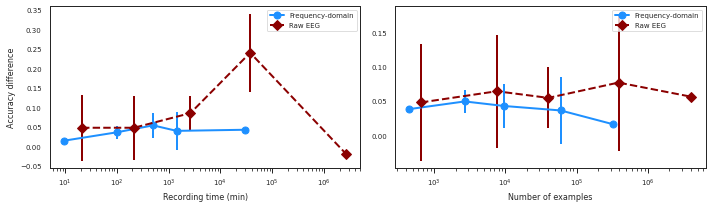

In [200]:
fig, axes = plt.subplots(
    ncols=2, figsize=(10, 3))
#     figsize=(save_cfg['text_width'], save_cfg['text_height'] / 3))
# axes = [axes]

axes[0].set(xscale='log', yscale='linear')
bins = None
for features, marker, color in zip([['Frequency-domain'], ['Raw EEG']], ['o-', 'D--'], ['dodgerblue', 'darkred']):
    
    if bins is None:
        bins = 5
    else:
        pass
    x = binned_statistic(
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col2]),
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col2]),
        statistic="mean", bins=bins)
    print(pd.Series(x[2]).value_counts())
    bins = 5
    x = pd.Series(x[0]).dropna()
    x = np.power(10, x)
    y = pd.Series(binned_statistic(
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col2]),
        data_df[data_df['Features (clean)'].isin(features)]['Difference'],
        statistic="mean", bins=bins)[0]).dropna()
    e = pd.Series(binned_statistic(
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col2]),
        data_df[data_df['Features (clean)'].isin(features)]['Difference'],
        statistic="std", bins=bins)[0]).dropna()
    axes[0].errorbar(x, y, yerr=e, xerr=None, fmt=marker, label=features[0], color=color, linewidth=2, markersize=7)
axes[0].legend()
# min_val = int(np.floor(np.log10(np.max([0.01, bins.min()]))))
# max_val = int(np.ceil(np.log10(bins.max())))
# axes[0].set_xticks(np.power(10, range(min_val, max_val + 1)))
axes[0].set_xlabel('Recording time (min)')
axes[0].set_ylabel('Accuracy difference')

axes[1].set(xscale='log', yscale='linear')

bins = None
for features, marker, color in zip([['Frequency-domain'], ['Raw EEG']], ['o-', 'D--'], ['dodgerblue', 'darkred']):
        
    if bins is None:
        bins = 5
    else:
        pass
    x = binned_statistic(
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col]),
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col]),
        statistic="mean", bins=bins)
    print(pd.Series(x[2]).value_counts())
    bins = 5
    x = pd.Series(x[0])
    x = np.power(10, x)
    y = pd.Series(binned_statistic(
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col]),
        data_df[data_df['Features (clean)'].isin(features)]['Difference'],
        statistic="mean", bins=bins)[0])
    e = pd.Series(binned_statistic(
        np.log10(data_df[data_df['Features (clean)'].isin(features)][col2]),
        data_df[data_df['Features (clean)'].isin(features)]['Difference'],
        statistic="std", bins=bins)[0])
    axes[1].errorbar(x, y, yerr=e, xerr=None, fmt=marker, label=features[0], color=color, linewidth=2, markersize=7)
axes[1].legend()
min_val = int(np.floor(np.log10(x.min())))
max_val = int(np.ceil(np.log10(x.max())))
# axes[1].set_xticks(np.power(10, range(min_val, max_val + 1)))
axes[1].set_xlabel('Number of examples')


# gs00 = mpl.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=axes[2])
# ax0 = fig.add_subplot(gs00[0])
# ax1 = fig.add_subplot(gs00[1])

# ax0.set(xscale='log', yscale='linear')
# bins=None
# for features, marker, color in zip([['Frequency-domain'], ['Raw EEG']], ['o-', 'D--'], ['dodgerblue', 'darkred']):
#     if bins is None:
#         bins = 5
#     else:
#         pass
#     x = binned_statistic(
#         np.log10(data_df[data_df['Features (clean)'].isin(features)][col2]),
#         np.log10(data_df[data_df['Features (clean)'].isin(features)][col2]),
#         statistic="mean", bins=bins)
#     bins = 5
#     x = pd.Series(x[0]).dropna()
#     x = np.power(10, x)
#     y = pd.Series(binned_statistic(
#         np.log10(data_df[data_df['Features (clean)'].isin(features)][col2]),
#         data_df[data_df['Features (clean)'].isin(features)]['Difference'],
#         statistic="count", bins=5)[0]).dropna()
#     ax0.plot(x, y, marker, label=features[0], color=color, linewidth=2, markersize=7)
# ax0.legend()
# min_val = int(np.floor(np.log10(x.min())))
# max_val = int(np.ceil(np.log10(x.max())))
# # axes[2].set_xticks(np.power(10, range(min_val, max_val + 1)))
# ax0.set_xlabel('Number of examples')


# ax1.set(xscale='log', yscale='linear')
# bins=None
# for features, marker, color in zip([['Frequency-domain'], ['Raw EEG']], ['o-', 'D--'], ['dodgerblue', 'darkred']):
#     if bins is None:
#         bins = 5
#     else:
#         pass
#     x = binned_statistic(
#         np.log10(data_df[data_df['Features (clean)'].isin(features)][col]),
#         np.log10(data_df[data_df['Features (clean)'].isin(features)][col]),
#         statistic="mean", bins=bins)
#     bins = 5
#     x = pd.Series(x[0]).dropna()
#     x = np.power(10, x)
#     y = pd.Series(binned_statistic(
#         np.log10(data_df[data_df['Features (clean)'].isin(features)][col]),
#         data_df[data_df['Features (clean)'].isin(features)]['Difference'],
#         statistic="count", bins=5)[0]).dropna()
#     ax1.plot(x, y, marker, label=features[0], color=color, linewidth=2, markersize=7)
# ax1.legend()
# min_val = int(np.floor(np.log10(x.min())))
# max_val = int(np.ceil(np.log10(x.max())))
# # axes[2].set_xticks(np.power(10, range(min_val, max_val + 1)))
# ax1.set_xlabel('Number of examples')
fig.tight_layout()
plt.savefig('../figs/dataset_size_vs_acc.png', dpi=350)

BinnedStatisticResult(statistic=array([1.23543129, 2.32085476, 3.10185201, 4.33072706, 5.45294852]), bin_edges=array([0.76342799, 1.78021003, 2.79699207, 3.8137741 , 4.83055614,
       5.84733818]), binnumber=array([2, 3, 2, 3, 3, 2, 2, 3, 2, 3, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1,
       1, 2, 3, 2, 2, 3, 3, 3, 2, 2, 4, 4, 4, 4, 4, 4, 2, 2, 1, 2, 1, 2,
       2, 3, 2, 1, 1, 1, 5, 4, 5, 4, 4, 2], dtype=int64))
BinnedStatisticResult(statistic=array([1.32555045, 2.37210231, 3.27262338, 4.5733987 , 6.43010732]), bin_edges=array([0.60205999, 1.76766946, 2.93327892, 4.09888839, 5.26449785,
       6.43010732]), binnumber=array([3, 3, 2, 2, 3, 1, 2, 2, 3, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 3, 1, 2, 3, 2, 2, 2, 2,
       2, 4, 2, 3, 3, 4, 2, 4, 1, 1, 2, 1, 2, 2, 2, 2, 3, 2, 1, 1, 2, 4,
       4, 2, 4, 3, 2, 1, 3, 2, 1, 1, 1, 1, 4, 4, 4, 3, 4, 5, 3],
      dtype=int64))
BinnedStatisticResult(statistic=array([2.49830654, 3.54887454, 4.2285355 ,

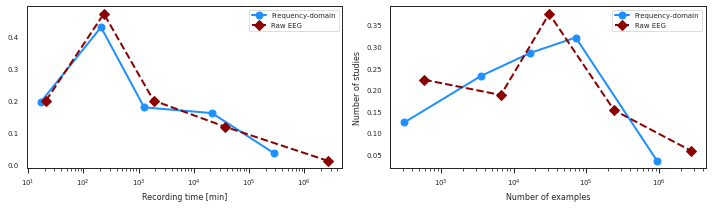

In [185]:
fig, axes = plt.subplots(
    ncols=2, figsize=(10, 3))
axes[0].set(xscale='log', yscale='linear')
bins=None
for features, marker, color in zip([['Frequency-domain'], ['Raw EEG']], ['o-', 'D--'], ['dodgerblue', 'darkred']):
    if bins is None:
        bins = 5
    else:
        pass
    x = binned_statistic(
        np.log10(data_df_beg[data_df_beg['Features (clean)'].isin(features)][col2]),
        np.log10(data_df_beg[data_df_beg['Features (clean)'].isin(features)][col2]),
        statistic="mean", bins=bins)
    print(x)
    bins = 5
    x = pd.Series(x[0])
    x = np.power(10, x)
    y = pd.Series(binned_statistic(
        np.log10(data_df_beg[data_df_beg['Features (clean)'].isin(features)][col2]),
        data_df_beg[data_df_beg['Features (clean)'].isin(features)]['Citation'],
        statistic="count", bins=bins)[0])
    y=y/y.sum()
    axes[0].plot(x, y, marker, label=features[0], color=color, linewidth=2, markersize=7)
axes[0].legend()
min_val = int(np.floor(np.log10(x.min())))
max_val = int(np.ceil(np.log10(x.max())))
# axes[2].set_xticks(np.power(10, range(min_val, max_val + 1)))
axes[0].set_xlabel('Recording time [min]')
axes[1].set_ylabel('Number of studies')


axes[1].set(xscale='log', yscale='linear')
bins=None
for features, marker, color in zip([['Frequency-domain'], ['Raw EEG']], ['o-', 'D--'], ['dodgerblue', 'darkred']):
    if bins is None:
        bins = 5
    else:
        pass
    x = binned_statistic(
        np.log10(data_df_beg[data_df_beg['Features (clean)'].isin(features)][col]),
        np.log10(data_df_beg[data_df_beg['Features (clean)'].isin(features)][col]),
        statistic="mean", bins=bins)
    print(x)
    bins = 5
    xerr = x[1]
    x = pd.Series(x[0]).dropna()
    x = np.power(10, x)
    y = pd.Series(binned_statistic(
        np.log10(data_df_beg[data_df_beg['Features (clean)'].isin(features)][col]),
        data_df_beg[data_df_beg['Features (clean)'].isin(features)]['Citation'],
        statistic="count", bins=bins)[0]).dropna()
    y = y/y.sum()
    axes[1].errorbar(x, y, yerr=None, xerr=None, fmt=marker, label=features[0], color=color, linewidth=2, markersize=7)
axes[1].legend()
min_val = int(np.floor(np.log10(x.min())))
max_val = int(np.ceil(np.log10(x.max())))
# axes[2].set_xticks(np.power(10, range(min_val, max_val + 1)))
axes[1].set_xlabel('Number of examples')
plt.tight_layout()

In [141]:
[np.mean(xerr[i:i+1]) for i in range(len(xerr)-1)]

[2.3344537511509307,
 3.2137904801684662,
 4.093127209186001,
 4.9724639382035365,
 5.851800667221072]

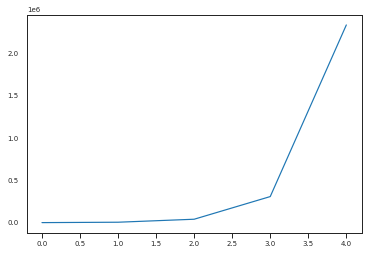

In [139]:
plt.plot(np.diff(10**xerr)/2)

In [135]:
10**xerr

array([2.16000000e+02, 1.63602705e+03, 1.23915950e+04, 9.38564099e+04,
       7.10887155e+05, 5.38440100e+06])

In [22]:
acc_df_best_proposed = acc_df[acc_df['model_type'] == 'Proposed'].sort_values('Result', ascending=False).drop_duplicates('citation_task')
acc_df_best_baseline_trad = acc_df[acc_df['model_type'] == 'Baseline (traditional)'].sort_values('Result', ascending=False).drop_duplicates('citation_task')

In [27]:
acc_df_best_proposed['citation_task'].unique()

array(['Almogbel2018 [mental workload classification]',
       'Patanaik2018 [sleep staging]',
       'Hussein2018 [seizure detection (2-class, hold-out)]',
       'Hussein2018 [seizure detection (2-class, LOSO)]',
       'Hussein2018 [seizure detection (2-class, 10-CV)]',
       'Hussein2018 [seizure detection (2-class B, hold-out)]',
       'Hussein2018 [seizure detection (2-class B, 10-CV)]',
       'Hussein2018 [seizure detection (3-class, hold-out)]',
       'Hussein2018 [seizure detection (3-class, LOSO)]',
       'Hussein2018 [seizure detection (3-class, 10-CV)]',
       'Hussein2018 [seizure detection (5-class, hold-out)]',
       'Hussein2018 [seizure detection (5-class, 10-CV)]',
       'Perez-Benitez2018 [SSVEP (normalized spectrum)]',
       'Ghosh2018 [exercise vs. control group classification]',
       'Zhang2018c [motor imagery]', 'Yoon2018 [ERP speller]',
       'Lee2018 [generating images of specific class]',
       'Hefron2018 [cognitive workload classification (len=5

In [6]:
# Remove N/M and TBD
col = 'Data - samples'
data_df.loc[data_df[col].isin(['N/M', 'TBD', '[TBD]']), col] = np.nan
data_df[col] = data_df[col].astype(float)

col2 = 'Data - time'
data_df.loc[data_df[col2].isin(['N/M', 'TBD', '[TBD]']), col2] = np.nan
data_df[col2] = data_df[col2].astype(float)

# Wrap main domain text
data_df['Main domain'] = data_df['Main domain'].apply(
    ut.wrap_text, max_char=13)

In [4]:
data_df = ut.split_column_with_multiple_entries(
    df, ['Data - samples', 'Data - time'], ref_col=['Citation', 'Main domain', 'Features (clean)'], 
    sep=';\n', lower=False)

c:\Users\ms261489\Documents\src\dl-eeg-review\code\utils.py:106: UserWarning: 1 rows had incompatible numbers of elements in the columns of interest and were dropped:
  warnings.warn('{} rows had incompatible numbers of elements in the '
c:\Users\ms261489\Documents\src\dl-eeg-review\code\utils.py:110: UserWarning: 	Morabito2016
  warnings.warn('\t{}'.format(df.iloc[i].loc['Citation']))


In [5]:
data_df.shape

(180, 5)

In [13]:
pd.isnull(data_df['Data - samples']).sum()

18

[None, None]

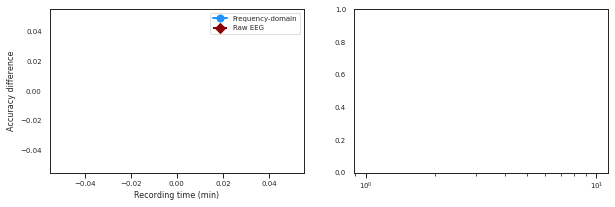

In [147]:
fig, axes = plt.subplots(
    ncols=2, figsize=(10, 3))
#     figsize=(save_cfg['text_width'], save_cfg['text_height'] / 3))
# axes = [axes]

# axes[0].set(xscale='log', yscale='linear')
bins = None
for features, marker, color in zip([['Frequency-domain'], ['Raw EEG']], ['o-', 'D--'], ['dodgerblue', 'darkred']):
    
    if bins is None:
        bins = 5
    else:
        pass
    x = binned_statistic(
        data_df[data_df['Features (clean)'].isin(features)][col2],
        data_df[data_df['Features (clean)'].isin(features)][col2],
        statistic="mean", bins=bins)
    bins = 5
    x = pd.Series(x[0]).dropna()
    x = np.power(10, x)
    y = pd.Series(binned_statistic(
        data_df[data_df['Features (clean)'].isin(features)][col2],
        data_df[data_df['Features (clean)'].isin(features)]['Difference'],
        statistic="mean", bins=bins)[0]).dropna()
    e = pd.Series(binned_statistic(
        data_df[data_df['Features (clean)'].isin(features)][col2],
        data_df[data_df['Features (clean)'].isin(features)]['Difference'],
        statistic="std", bins=bins)[0]).dropna()
    axes[0].errorbar(x, y, yerr=e, xerr=None, fmt=marker, label=features[0], color=color, linewidth=2, markersize=7)
axes[0].legend()
# min_val = int(np.floor(np.log10(np.max([0.01, bins.min()]))))
# max_val = int(np.ceil(np.log10(bins.max())))
# axes[0].set_xticks(np.power(10, range(min_val, max_val + 1)))
axes[0].set_xlabel('Recording time (min)')
axes[0].set_ylabel('Accuracy difference')

axes[1].set(xscale='log', yscale='linear')

# bins = None
# for features, marker, color in zip([['Frequency-domain'], ['Raw EEG']], ['o-', 'D--'], ['dodgerblue', 'darkred']):
        
#     if bins is None:
#         bins = 5
#     else:
#         pass
#     x = binned_statistic(
#         np.log10(data_df[data_df['Features (clean)'].isin(features)][col]),
#         np.log10(data_df[data_df['Features (clean)'].isin(features)][col]),
#         statistic="mean", bins=bins)
#     bins = 5
#     x = pd.Series(x[0])
#     x = np.power(10, x)
#     y = pd.Series(binned_statistic(
#         np.log10(data_df[data_df['Features (clean)'].isin(features)][col]),
#         data_df[data_df['Features (clean)'].isin(features)]['Difference'],
#         statistic="mean", bins=bins)[0])
#     e = pd.Series(binned_statistic(
#         np.log10(data_df[data_df['Features (clean)'].isin(features)][col2]),
#         data_df[data_df['Features (clean)'].isin(features)]['Difference'],
#         statistic="std", bins=bins)[0])
#     axes[1].errorbar(x, y, yerr=e, xerr=None, fmt=marker, label=features[0], color=color, linewidth=2, markersize=7)
# axes[1].legend()
# min_val = int(np.floor(np.log10(x.min())))
# max_val = int(np.ceil(np.log10(x.max())))
# # axes[1].set_xticks(np.power(10, range(min_val, max_val + 1)))
# axes[1].set_xlabel('Number of examples')

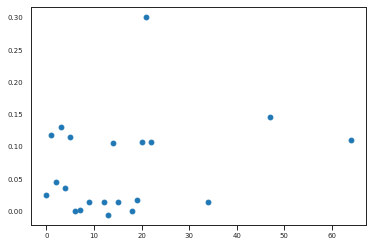

In [173]:
plt.plot(binned_statistic(
        data_df[data_df['Features (clean)'].isin(features)][col2],
        data_df[data_df['Features (clean)'].isin(features)]['Difference'],
        statistic="mean", bins=100000)[0][:-99900], 'o')

<AxesSubplot:>

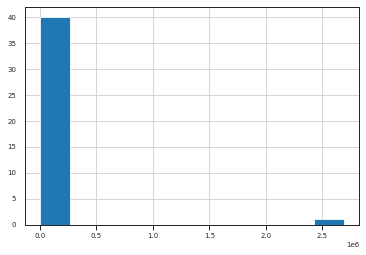

In [154]:
data_df[data_df['Features (clean)'].isin(features)][col2].hist()